In [1]:
# Cell 1: imports
import numpy as np
import matplotlib.pyplot as plt

from NeuronModel import NeuronModel
from Animations_GPT import (
    VOLTAGE_LIMITS,
    make_folder,
    animate_phase_portrait,
    animate_trajectories,
    animate_timeseries,
    animate_color_square,
)

# optional: inline plots, though animations will be saved as files:
%matplotlib inline

# Choose a base folder where all animations/images will go
BASE_OUTPUT_DIR = r"C:/Users/local_user/Desktop/Study/VII_semester_Legion/Modelling_Neurons/NeuronDynamics/Jupyter_Experiments"


c:\Users\local_user\Desktop\Study\VII_semester\Modelling_Neurons\NeuronDynamics\NeuronModel.py:267: RuntimeWarning: divide by zero encountered in divide
  return (I_ext - self.I_Na(V) - self.I_L(V)) / (self.g_K * (V - self.E_K))


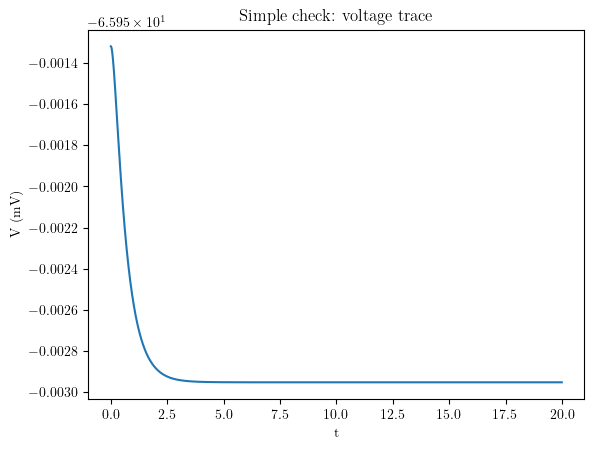

In [2]:
# Cell 2: plain simulation & static plot as a sanity check

neuron = NeuronModel('saddle-node')           # or 'saddle-node', 'subcritical_Hopf', 'supercritical_Hopf'
T = 20
dt = 0.01
t = np.arange(0, T, dt)

# Start near a stable equilibrium at I_ext = 0
eqs = neuron.find_equlibrium_points(0, [VOLTAGE_LIMITS[0], VOLTAGE_LIMITS[1]])
stable_eq = [eq for eq in eqs if eq['stability'] == 'stable'][0]
X0 = list(stable_eq['point'])

I_ext = 0  # constant current injection
t, sol = neuron.simulate(T, dt, X0, lambda tt: I_ext)

V = sol[:, 0]
n = sol[:, 1]

plt.figure()
plt.plot(t, V)
plt.xlabel("t")
plt.ylabel("V (mV)")
plt.title("Simple check: voltage trace")
plt.show()


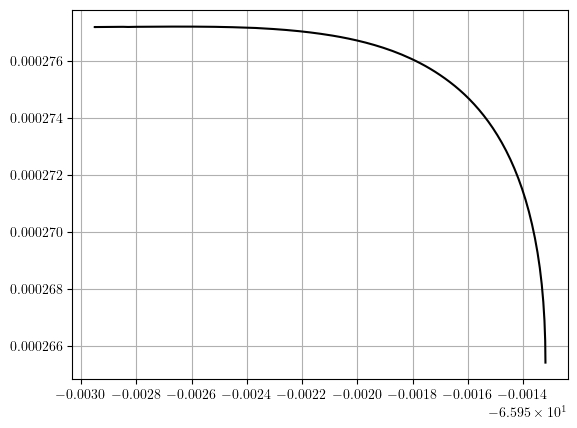

In [3]:
fig, ax = plt.subplots()
ax.plot(V, n, color="black")
ax.grid(True)
plt.show()


In [9]:
# Cell 3: animate a single trajectory in phase space

save_dir = make_folder(
    "SNIC_single_trajectory",
    root_dir=BASE_OUTPUT_DIR
)

animate_trajectories(
    t=t,
    solutions=[sol],          # list of trajectories
    colors=['black'],       # one color per trajectory
    save_folder=save_dir,
    subsample=1,
    trail_length=None,        # None = full trace
    suffix="demo",
    display_start_times=None, # or a scalar / list of times
    markersize=6,
    lw=2.5,
)


100%|█████████▉| 1999/2000 [02:19<00:00, 13.84it/s]

Saved trajectory animation to C:\Users\local_user\Desktop\Study\VII_semester_Legion\Modelling_Neurons\NeuronDynamics\Jupyter_Experiments\SNIC_single_trajectory\trajectory_demo.mp4


100%|█████████▉| 1999/2000 [02:36<00:00, 13.84it/s]

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from NeuronModel import NeuronModel
import cmasher as cmr


VOLTAGE_LIMITS = (-90, 20)

def plot_phase_plane_like_artem(
    neuron,
    I_ext,
    v_range=VOLTAGE_LIMITS,
    n_range=(0, 1),
    n_y_range=(-0.1, 1),
    vector_field_resolution=30,
):
    cmap = cmr.get_sub_cmap(plt.cm.Blues, 0.3, 1)
    #cmap = cmr.get_sub_cmap(plt.cm.Greys_r, 0.15, 0.8)
    # --- grid for vector field (same as in Animations.py)
    x = np.linspace(v_range[0], v_range[1], vector_field_resolution)
    y = np.linspace(n_range[0], n_range[1], vector_field_resolution)
    X, Y = np.meshgrid(x, y)

    # same derivative logic as in animate_vector_field
    dVdt, dndt = neuron.dALLdt([X, Y], 0.0, lambda t: I_ext)
    dndt_amplified = dndt * 100.0          # Artem’s trick

    norm = np.sqrt(dVdt**2 + dndt_amplified**2)
    dxdt_norm = dVdt / norm
    dydt_norm = dndt_amplified / norm

    # --- nullclines
    V_high_res = np.linspace(v_range[0], v_range[1], 1000)
    n_v_null = neuron.V_nullcline(V_high_res, I_ext)
    n_n_null = neuron.n_nullcline(V_high_res)

    # --- equilibria
    equilibria = neuron.find_equlibrium_points(I_ext, v_range)

    # ---------- plotting ----------
    fig, ax = plt.subplots(figsize=(7, 7), dpi=150)
    fig.patch.set_facecolor("white")
    ax.set_facecolor("white")

    # vector field: EXACTLY Artem’s normalized field,
    # but colored with a blue colormap instead of greys
    quiv = ax.quiver(
        X, Y,
        dxdt_norm, dydt_norm,
        norm,                      # color by speed
        cmap=cmap,
        alpha=1,
        headwidth=4,
        headlength=3,
        headaxislength=2,
        pivot="mid",
    )

    # nullclines
    ax.plot(V_high_res, n_v_null, color="red",   lw=2.5, label="V-nullcline")
    ax.plot(V_high_res, n_n_null, color="green", lw=2.5, label="n-nullcline")

    # equilibrium points (same styling as before)
    for eq in equilibria:
        v0, n0 = eq["point"]
        stab = eq["stability"]
        if stab == "stable":
            ax.plot(v0, n0, "o", color="black", markersize=6)
        elif stab == "unstable":
            ax.plot(
                v0, n0, "o",
                markerfacecolor="white",
                markeredgecolor="black",
                markersize=8, mew=1.5,
            )
        elif stab == "saddle":
            ax.plot(v0, n0, "x", color="black", markersize=8, mew=2)

    ax.set_xlim(v_range)
    ax.set_ylim(n_y_range)

    ax.set_xlabel("Voltage", fontsize=14)
    ax.set_ylabel("Frac. of potassium channels", fontsize=14)
    ax.grid(True, color="0.9")
    ax.tick_params(labelsize=12)
    ax.legend(frameon=False, loc="best")

    plt.tight_layout()
    return fig, ax


In [5]:
VOLTAGE_LIMITS = (-90, 20)
N_Y_LIMITS = (-0.1, 1.0)  # or (-0.2, 1.0)

In [6]:
def plot_phase_plane_with_dynamics(
    neuron,
    I_ext,
    v_range=VOLTAGE_LIMITS,
    n_range=(0, 1),
    n_y_range=(-0.1, 1),
    vector_field_resolution=30,
    # trajectories
    traj_ics=None,          # list of (V0, n0)
    T_traj=20.0,
    dt_traj=0.01,
    traj_color="#000000",
    traj_alpha=0.9,
    # separatrix
    show_separatrix=False,
    separatrix_color="#AA00FF",
    separatrix_lw=2.5,
    # limit cycle
    show_limit_cycle=False,
    lc_T_total=400.0,       # total sim time for limit cycle
    lc_T_transient=200.0,   # throw away this much as transient
    lc_dt=0.01,
    limit_cycle_color="#FF8800",
    limit_cycle_lw=2.5,
    # **unstable limit cycle (subcritical Hopf)**
    show_unstable_limit_cycle=False,
    unstable_lc_color="#AA00FF",
    unstable_lc_lw=2.5,
):
    """
    Make Artem-style phase plane, then optionally add:
    - sample trajectories from initial conditions
    - separatrix
    - limit cycle

    Returns
    -------
    fig, ax
    """

    # base plot
    fig, ax = plot_phase_plane_like_artem(
        neuron,
        I_ext,
        v_range=v_range,
        n_range=n_range,
        n_y_range=n_y_range,
        vector_field_resolution=vector_field_resolution,
    )

    # ----- trajectories -------------------------------------------------
    if traj_ics is not None:
        for (V0, n0) in traj_ics:
            t, sol = neuron.simulate(T_traj, dt_traj, [V0, n0], lambda t: I_ext)
            ax.plot(
                sol[:, 0], sol[:, 1],
                color=traj_color,
                lw=1.6,
                alpha=traj_alpha,
            )
            # mark starting point
            ax.plot(sol[0, 0], sol[0, 1], "o",
                    color=traj_color, ms=4, alpha=traj_alpha)

    # ----- separatrix ---------------------------------------------------
    if show_separatrix:
        try:
            # use Artem's implementation, but with safer parameters
            V_sep, n_sep = neuron.find_separatrix(
                I_ext,
                x_range=v_range,
                t_max=40,      # smaller than 100 -> faster & fewer overflows
                dt=0.01,
                eps=1e-6,
            )

            # --- optional: keep only the branch that acts as basin boundary ---
            #    (this removes the "foot" going from the rest state to the saddle)
            equilibria = neuron.find_equlibrium_points(I_ext, v_range)
            saddle = [e for e in equilibria if e["stability"] == "saddle"][0]
            V_sad, n_sad = saddle["point"]

            # keep only points to the *right* of the saddle (tweak if needed)
            mask = V_sep >= V_sad
            V_sep, n_sep = V_sep[mask], n_sep[mask]

            # also clip to plotting window just in case
            in_box = (
                (V_sep >= v_range[0]) & (V_sep <= v_range[1]) &
                (n_sep >= n_range[0]) & (n_sep <= n_range[1])
            )
            V_sep, n_sep = V_sep[in_box], n_sep[in_box]

            ax.plot(
                V_sep, n_sep,
                color=separatrix_color,
                lw=separatrix_lw,
                ls="--",
                label="Separatrix",
            )

        except Exception as e:
            print(f"[warn] Could not compute separatrix: {e}")

    # ----- limit cycle --------------------------------------------------
    if show_limit_cycle:
        try:
            # 1) find the unstable equilibrium
            equilibria = neuron.find_equlibrium_points(I_ext, v_range)
            unstable_eq = None
            for eq in equilibria:
                if eq["stability"] == "unstable":
                    unstable_eq = eq
                    break

            if unstable_eq is None:
                print("[warn] No unstable equilibrium found; cannot get limit cycle.")
            else:
                Vc, nc = unstable_eq["point"]

                # 2) small perturbation away from the equilibrium
                eps = 1e-3
                ic_cycle = [Vc + eps, nc + eps]

                # 3) long simulation so trajectory settles onto the LC
                t_lc, sol_lc = neuron.simulate(
                    lc_T_total, lc_dt, ic_cycle, lambda t: I_ext
                )

                # 4) discard transient and plot the rest
                mask = t_lc >= lc_T_transient
                V_cycle = sol_lc[mask, 0]
                n_cycle = sol_lc[mask, 1]

                ax.plot(
                    V_cycle, n_cycle,
                    color=limit_cycle_color,
                    lw=limit_cycle_lw,
                    label="Limit cycle",
                )
        except Exception as e:
            print(f"[warn] Could not compute limit cycle: {e}")


    # ----- UNSTABLE limit cycle (subcritical Hopf only) ---------------
    if show_unstable_limit_cycle:
        try:
            if getattr(neuron, "bifurcation_type", "") != "subcritical_Hopf":
                print("[warn] Unstable limit cycle requested, "
                      "but neuron.bifurcation_type is not 'subcritical_Hopf'.")
            else:
                # This uses Artem's NeuronModel.find_unstable_limit_cycle
                V_u, n_u = neuron.find_unstable_limit_cycle(
                    I_ext,
                    # you can pass dt / T_max here if you want to override defaults
                    #dt=0.025,
                    #T_max=2000,
                )
                V_u = np.r_[V_u, V_u[0]]
                n_u = np.r_[n_u, n_u[0]]
                if len(V_u) > 0:
                    ax.plot(
                        V_u, n_u,
                        color=unstable_lc_color,
                        lw=unstable_lc_lw,
                        ls="--",
                        label="Unstable limit cycle",
                    )
        except Exception as e:
            print(f"[warn] Could not compute unstable limit cycle: {e}")


    # avoid duplicate legend entries
    handles, labels = ax.get_legend_handles_labels()
    uniq = dict(zip(labels, handles))
    ax.legend(uniq.values(), uniq.keys(), frameon=False, loc="best")

    return fig, ax


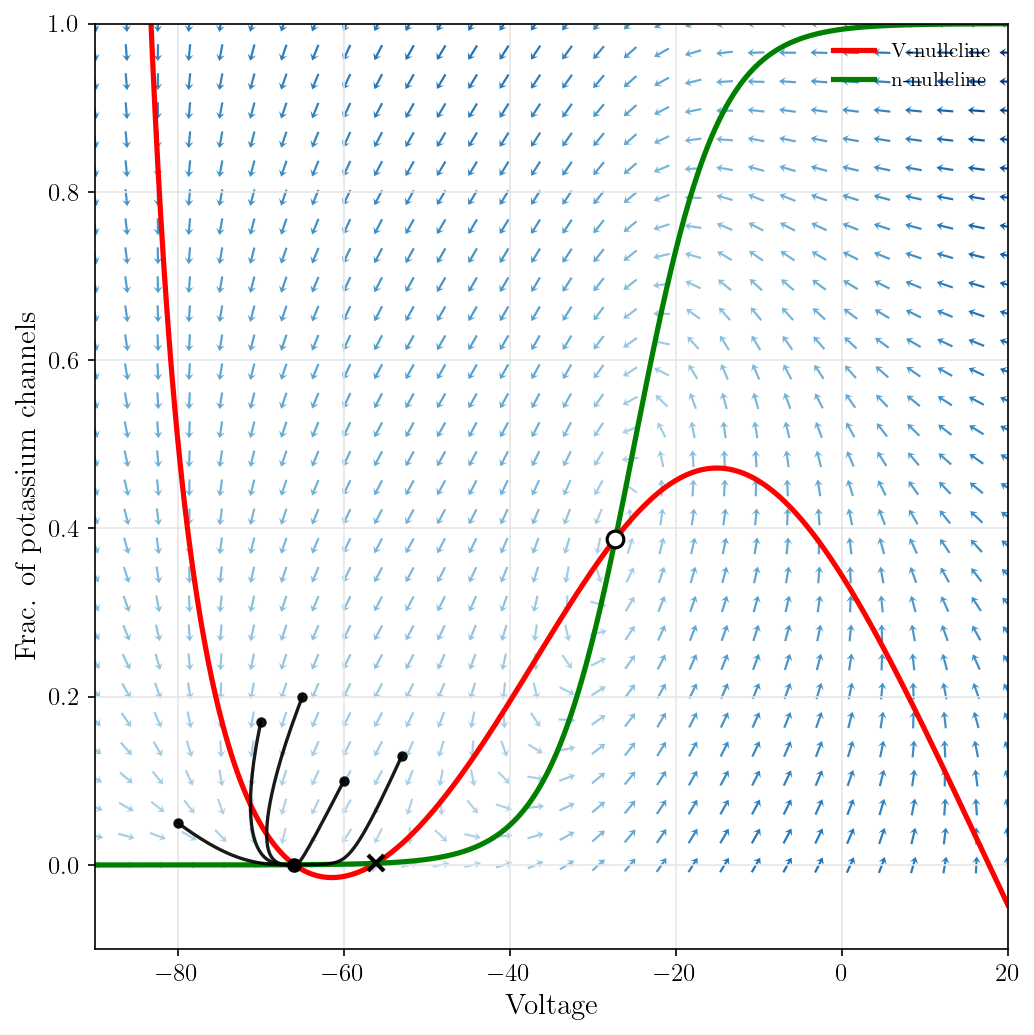

In [8]:
neuron_saddle = NeuronModel('saddle-node')   # or 'SNIC', 'subcritical_Hopf', 'supercritical_Hopf'

fig, ax = plot_phase_plane_with_dynamics(
    neuron_saddle,
    I_ext,
    n_y_range=N_Y_LIMITS,
    traj_ics=[(-80, 0.05), (-60, 0.1), (-65, 0.2), (-53, 0.13), (-70, 0.17)],
    T_traj=30,
    dt_traj=0.01,
    show_separatrix=False,
    show_limit_cycle=False,
)
plt.show()


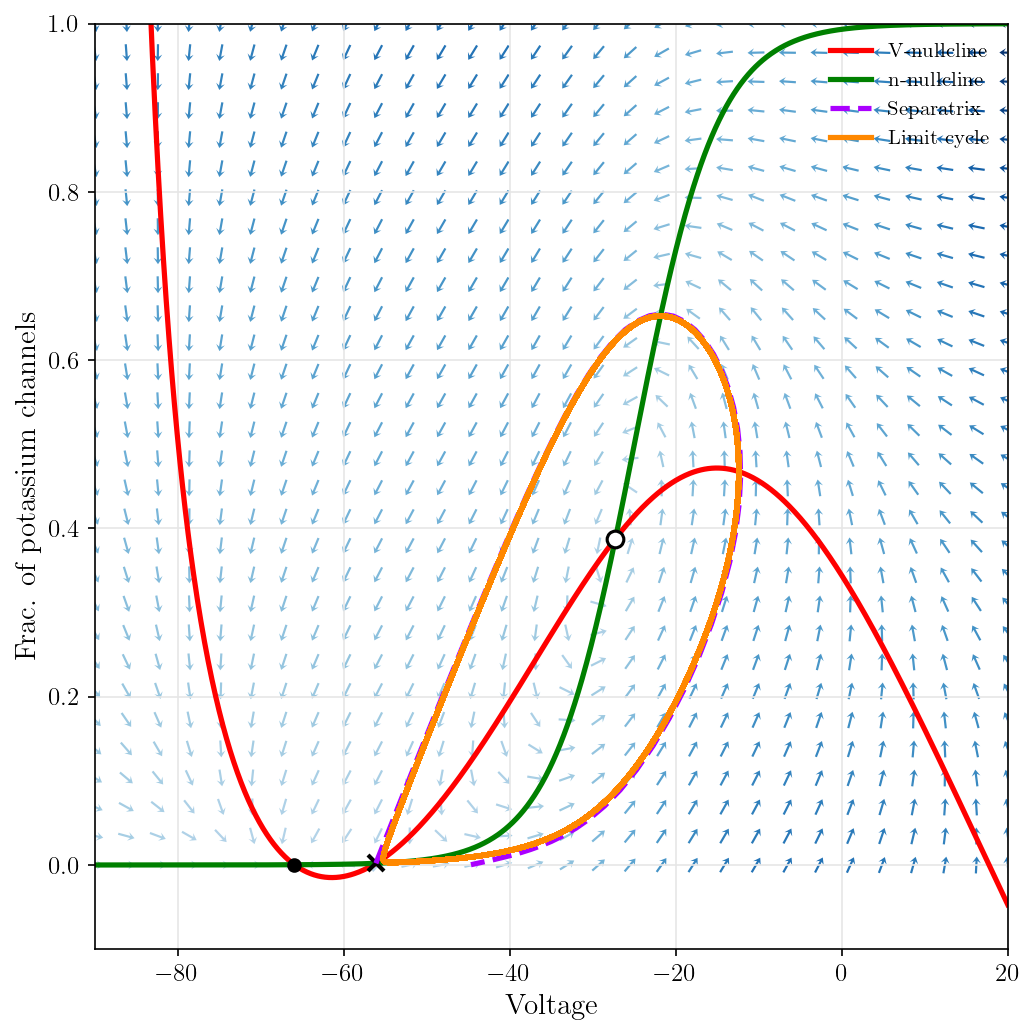

In [9]:
fig, ax = plot_phase_plane_with_dynamics(
    neuron_saddle,
    I_ext=0,
    n_y_range=N_Y_LIMITS,
    #traj_ics=[(-80, 0.05), (-60, 0.1), (-65, 0.2), (-53, 0.13), (-70, 0.17)],
    T_traj=30,
    dt_traj=0.01,
    show_separatrix=True,
    show_limit_cycle=True,
)
plt.show()

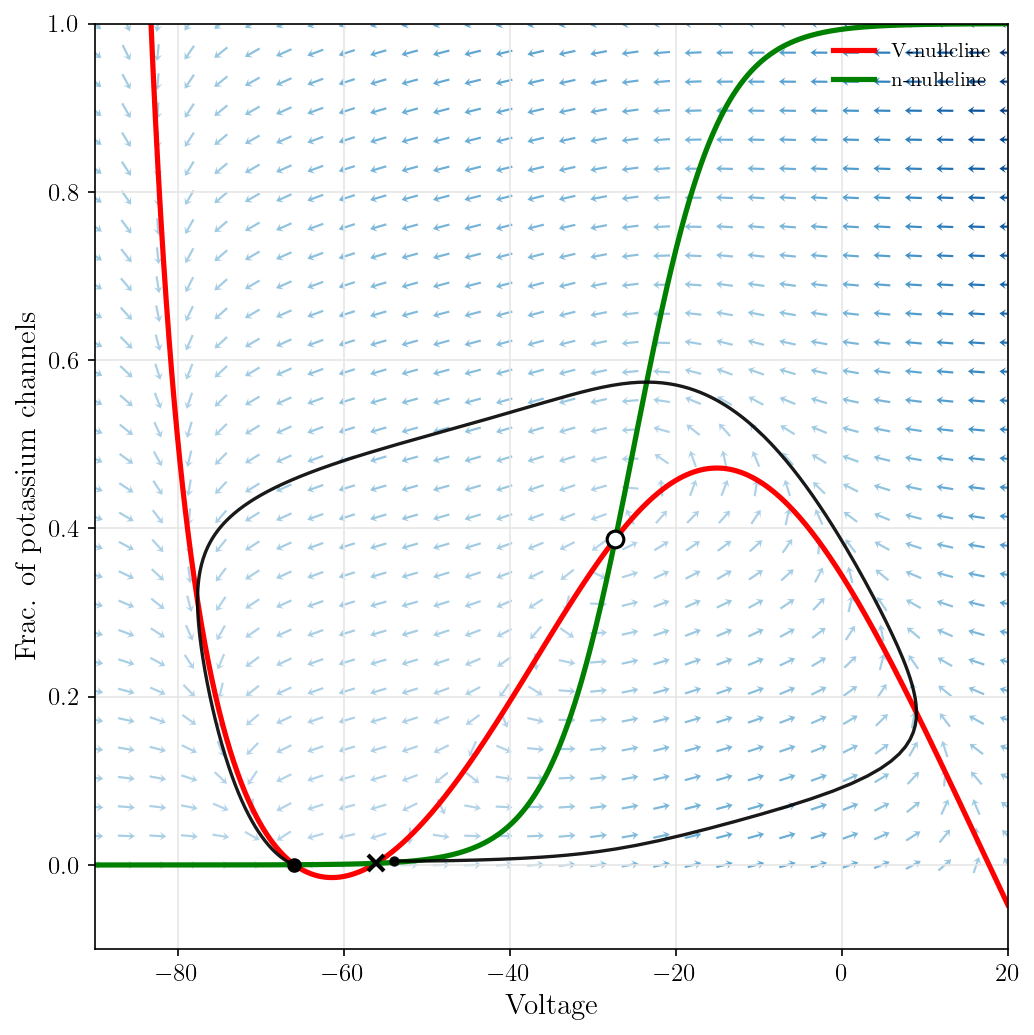

In [10]:
neuron_SNIC = NeuronModel('SNIC')   # or 'SNIC', 'subcritical_Hopf', 'supercritical_Hopf'

fig, ax = plot_phase_plane_with_dynamics(
    neuron_SNIC,
    I_ext,
    n_y_range=N_Y_LIMITS,
    traj_ics=[(-54, 0.005)],
    T_traj=30,
    dt_traj=0.01,
    show_separatrix=False,
    show_limit_cycle=False,
)
plt.show()


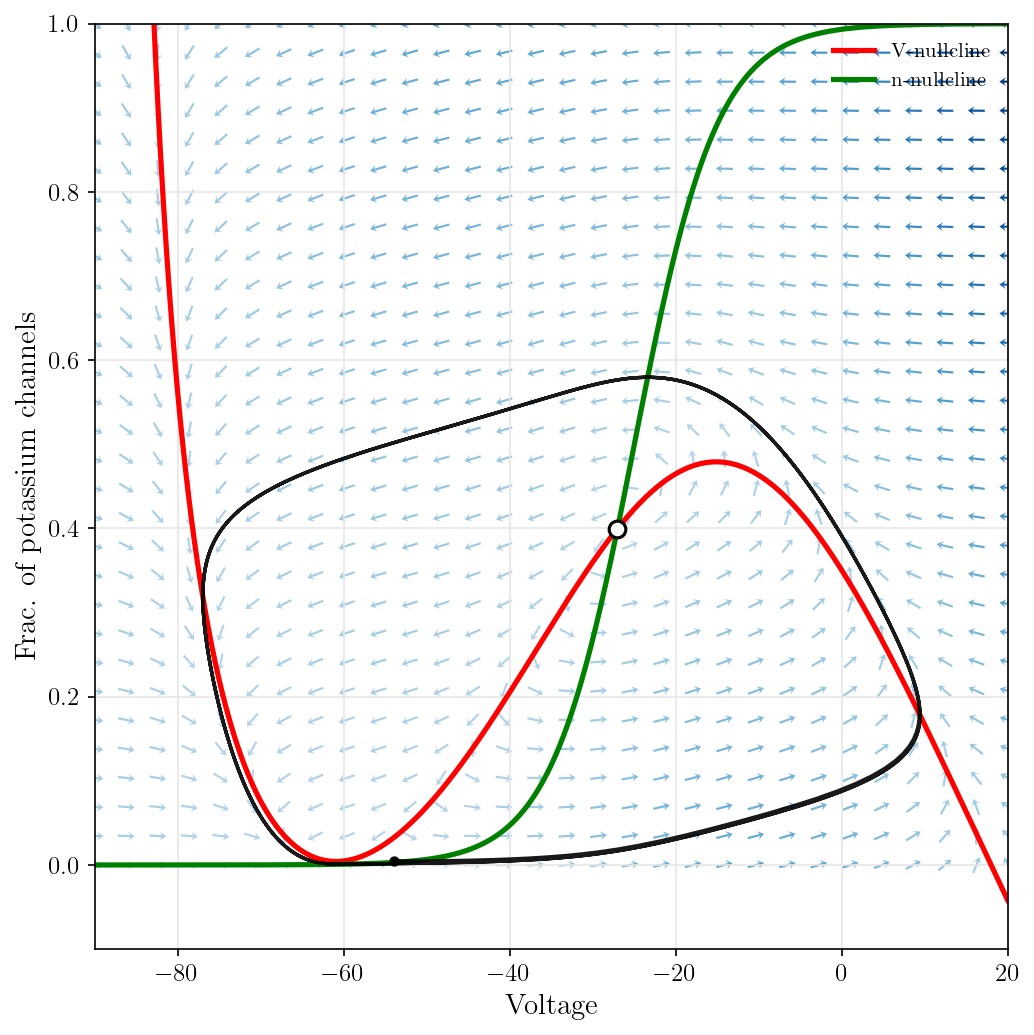

In [11]:
neuron_SNIC = NeuronModel('SNIC')   # or 'SNIC', 'subcritical_Hopf', 'supercritical_Hopf'

I_ext_SNIC = 5.52

fig, ax = plot_phase_plane_with_dynamics(
    neuron_SNIC,
    I_ext_SNIC,
    n_y_range=N_Y_LIMITS,
    traj_ics=[(-54, 0.005)],
    T_traj=30,
    dt_traj=0.01,
    show_separatrix=False,
    show_limit_cycle=False,
)
plt.show()


c:\Users\local_user\Desktop\Study\VII_semester\Modelling_Neurons\NeuronDynamics\NeuronModel.py:63: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-(V - self.V_mid_n) / self.k_n))
c:\Users\local_user\Desktop\Study\VII_semester\Modelling_Neurons\NeuronDynamics\NeuronModel.py:58: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-(V - self.V_mid_m) / self.k_m))


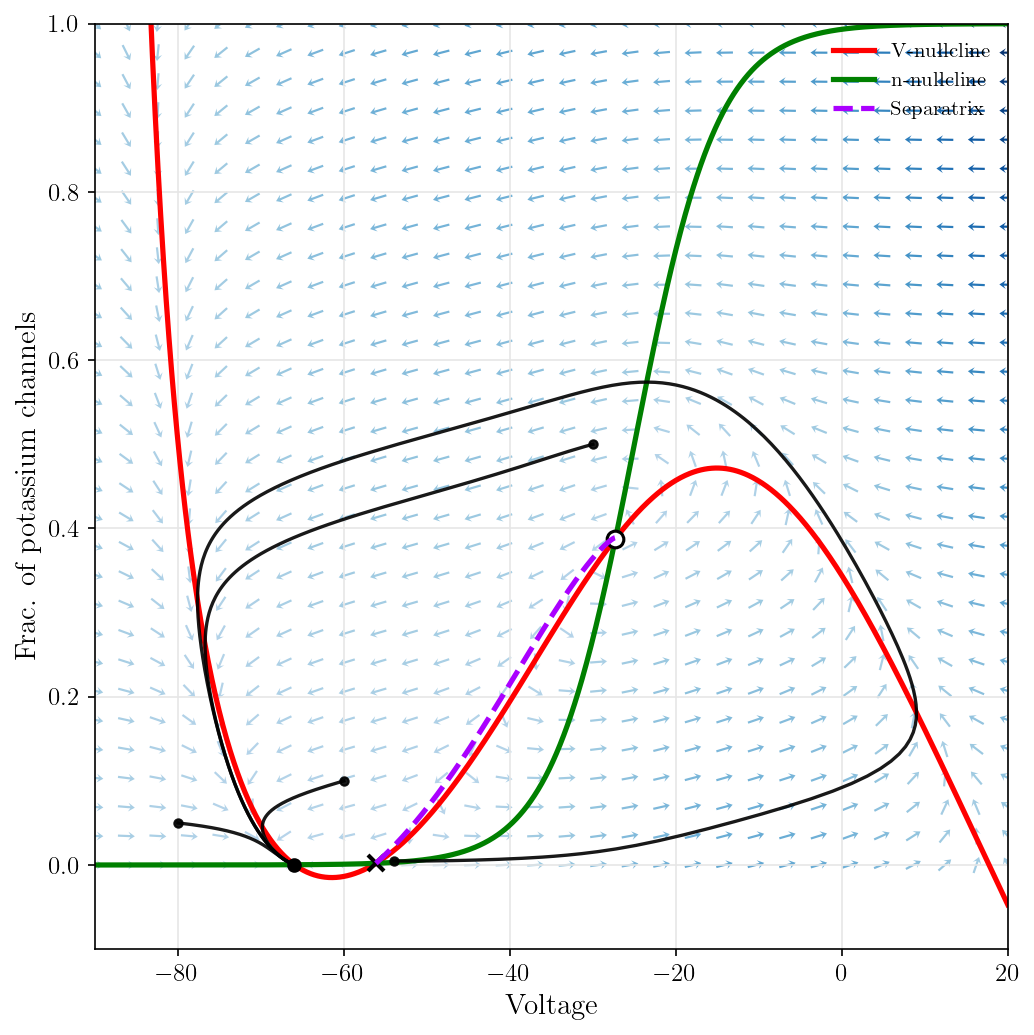

In [12]:
I_ext_SNIC = 0
fig, ax = plot_phase_plane_with_dynamics(
    neuron_SNIC,
    I_ext_SNIC,
    n_y_range=N_Y_LIMITS,
    traj_ics=[(-80, 0.05), (-60, 0.1), (-30, 0.5), (-54, 0.005)],
    T_traj=30,
    dt_traj=0.01,
    show_separatrix=True,
    show_limit_cycle=False,
)
plt.show()

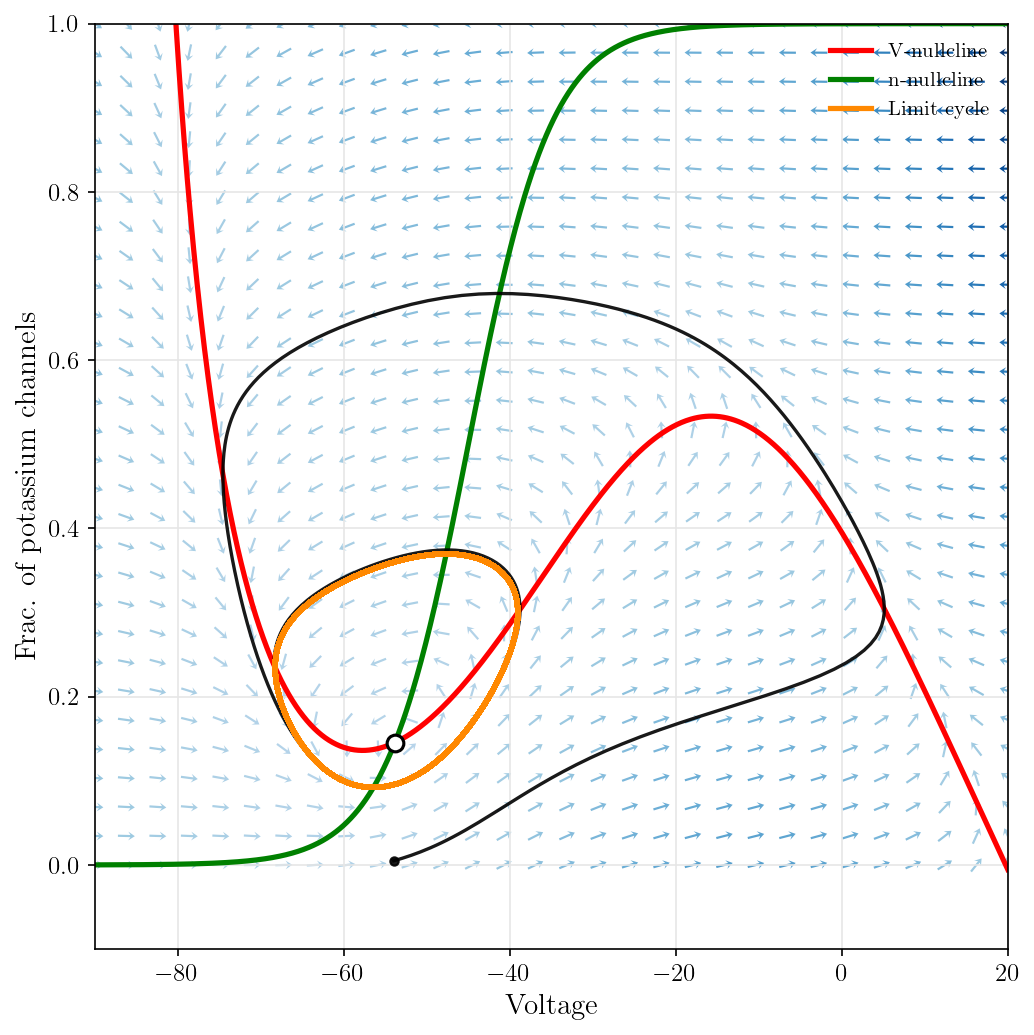

In [13]:
neuron_supH = NeuronModel('supercritical_Hopf')   # or 'SNIC', 'subcritical_Hopf', 'supercritical_Hopf'

I_ext_supH = 30

fig, ax = plot_phase_plane_with_dynamics(
    neuron_supH,
    I_ext_supH,
    n_y_range=N_Y_LIMITS,
    traj_ics=[(-54, 0.005)],
    T_traj=30,
    dt_traj=0.01,
    show_separatrix=False,
    show_limit_cycle=True,
)
plt.show()


[warn] No unstable equilibrium found; cannot get limit cycle.


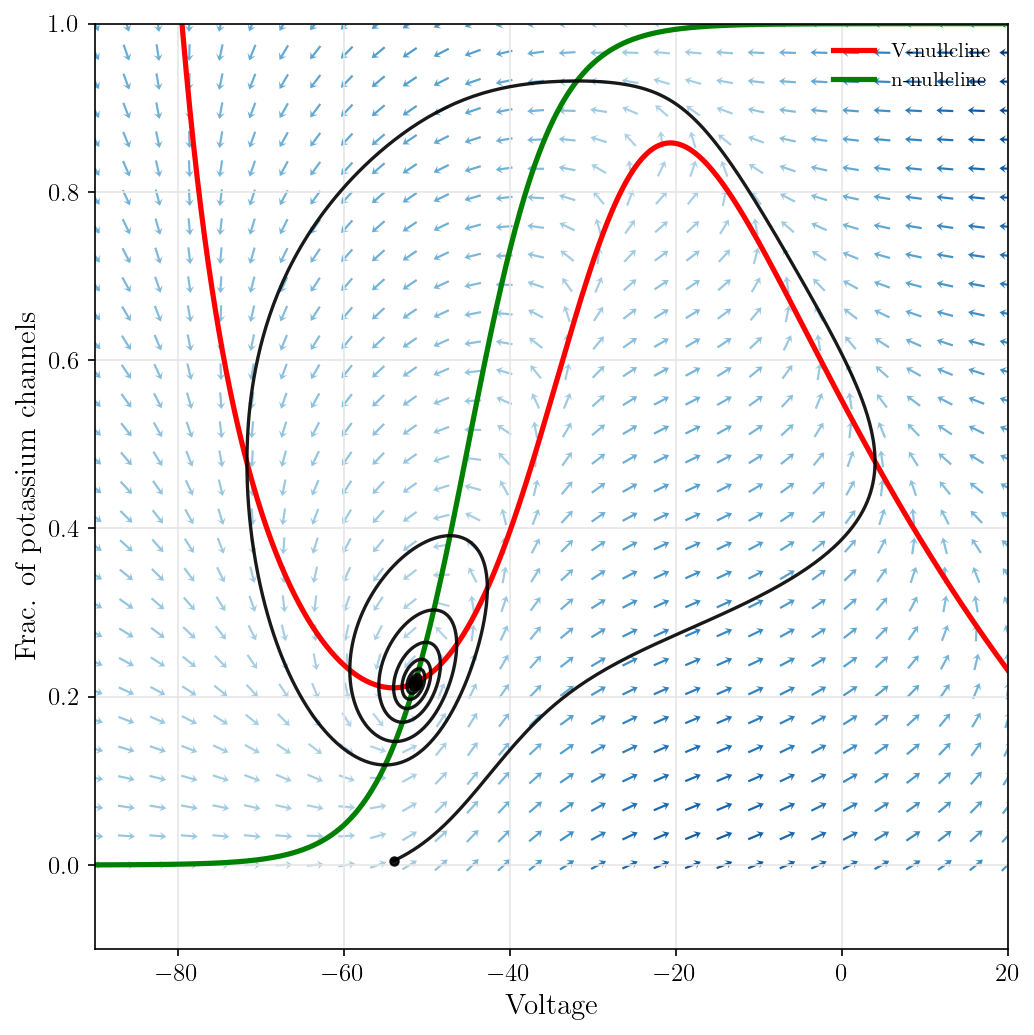

In [14]:
neuron_supH = NeuronModel('subcritical_Hopf')   # or 'SNIC', 'subcritical_Hopf', 'supercritical_Hopf'

I_ext_supH = 40

fig, ax = plot_phase_plane_with_dynamics(
    neuron_supH,
    I_ext_supH,
    n_y_range=N_Y_LIMITS,
    traj_ics=[(-54, 0.005)],
    T_traj=30,
    dt_traj=0.01,
    show_separatrix=False,
    show_limit_cycle=True,
)
plt.show()


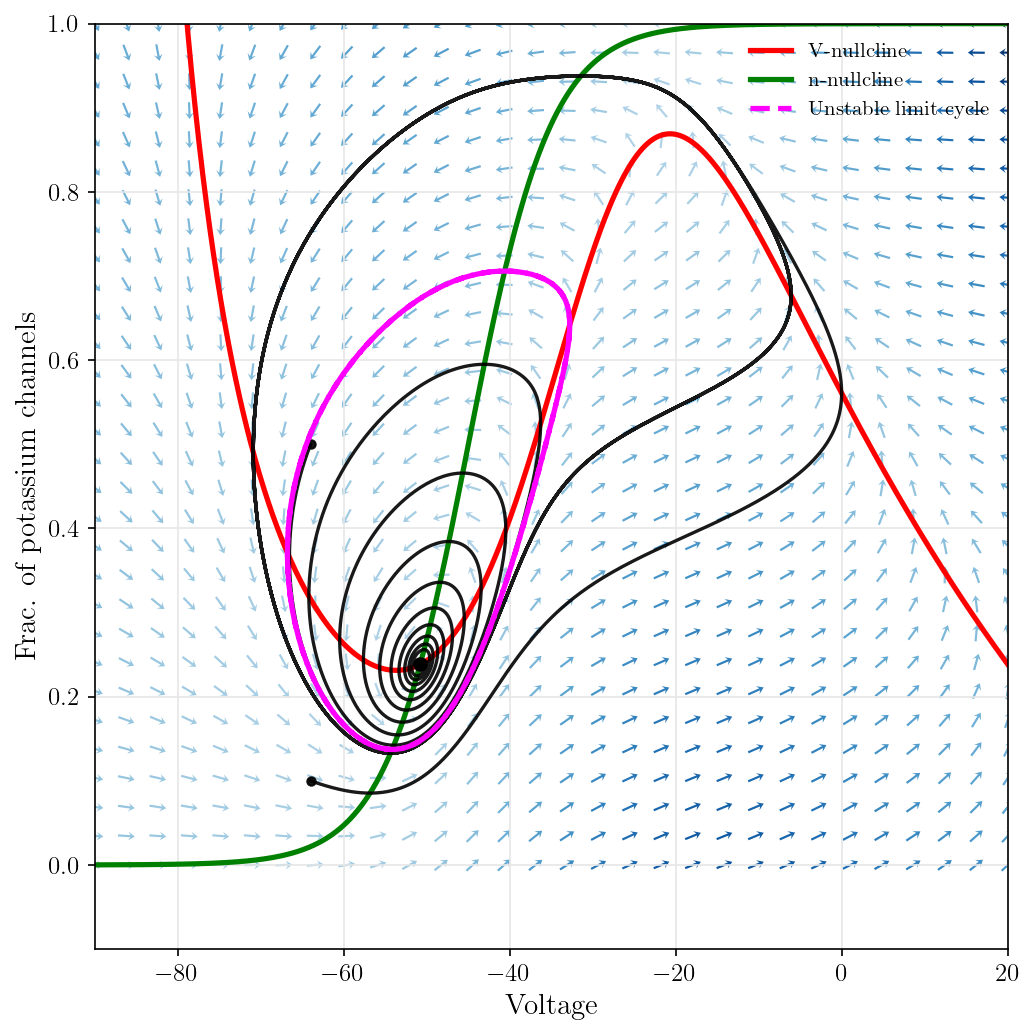

In [22]:
neuron_supH = NeuronModel("subcritical_Hopf")
I_ext_supH = 43

fig, ax = plot_phase_plane_with_dynamics(
    neuron_supH,
    I_ext_supH,
    traj_ics=[(-64, 0.1), (-64, 0.5)],
    T_traj=30,
    dt_traj=0.01,
    show_separatrix=False,
    show_limit_cycle=False,          # outer *stable* cycle
    show_unstable_limit_cycle=True, # inner *unstable* cycle
    limit_cycle_color="#000000",    # e.g. black outer
    unstable_lc_color="#FF00FF",    # e.g. magenta dashed inner
)
plt.show()
